In [1]:
#!pip install pandas requests beautifulsoup4 seaborn

### Import modules

In [2]:
import re
import os
import csv
import json
import shutil
import pandas
import base64
import requests
import numpy as np
import seaborn as sns
from pathlib import Path
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor

In [3]:
class StratNinja:
    def __init__(self, file_path, file_meta, save):
        self.file_path = file_path
        self.file_meta = file_meta
        self.save = save

        self.publics = []
        self.privates = []

        self.metadata = []
        self.processed = set()

        self.load_data()

    def load_data(self):
        self.metadata = []
        self.processed = set()

        if not self.file_meta or not os.path.exists(self.file_meta):
            return

        try:
            with open(self.file_meta, "r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        obj = json.loads(line)
                    except json.JSONDecodeError:
                        print(f"[WARN] Invalid line {self.file_meta}: {line[:80]}...")
                        continue
                    self.metadata.append(obj)
                    strat = obj.get("strategy")

                    if strat:
                        self.processed.add(strat)

        except Exception as e:
            print(f"load_data error: {e}")

    def save_data(self, row: dict):
        with open(self.file_meta, "a", encoding="utf-8") as f:
            f.write(json.dumps(row, ensure_ascii=False, separators=(",", ":")) + "\n")

        self.metadata.append(row)
        
        if row.get("strategy"):
            self.processed.add(row["strategy"])
    
    def get_public_strategies(self):
        resp = requests.request('GET', 'https://strat.ninja/strats.php')
        if resp.status_code == 200:
            rows = resp.text.splitlines()

            for row in rows:
                if re.search(r'target="_blank"', row):
                    match = re.search(r'href="overview.php\?strategy=(.*?)"', row)
                    if match:
                        name = match.group(1)
                        if 'private' in row.lower():
                            self.privates.append(name)
                        else:
                            self.publics.append(name)
            
    def get_user_strategies(self):
        pass

    def process_strategies(self, strategies):
        for index, strategy in enumerate(strategies):
            if strategy in self.processed:
                print(f"[{len(self.publics)}/{index + 1}] {strategy} skipping...")
                continue
            else:
                print(f"[{len(self.publics)}/{index + 1}] {strategy}")

            resp_info, tags = self.download_strategy_info(strategy)
            resp_code, code = self.download_strategy_code(strategy, self.save) if strategy not in self.privates else "", 404
            
            if not resp_code or not resp_info:
                continue
            
            scope = 'Public' if strategy in self.publics else 'Private'
            mode = self.get_mode(tags)
            timeframe = self.get_timeframe(tags)
            failed = self.get_failed(tags)
            bias = self.get_bias(tags)
            stalled = self.get_stalled(tags)
            leverage = self.get_leverage(tags)
            profit = self.get_profit(resp_info)
            short = self.get_short(resp_code)
            inds_set = self.get_indicators(resp_code)

            row = {
                "strategy": strategy,
                "scope": scope,
                "mode": mode,
                "timeframe": timeframe,
                "failed": failed,
                "bias": bias,
                "stalled": stalled,
                "leverage": leverage,
                "short": short,
                "profit": profit,
            }
            row.update({ind: 1 for ind in inds_set})
            self.save_data(row)

    def download_strategy_info(self, strategy):
        try:
            resp = requests.request("GET", f"https://strat.ninja/overview.php?strategy={strategy}")

            soup = BeautifulSoup(resp.text, features="html.parser")
            tags = soup.find("div", class_="tags")

            elements = []
            for tag in tags.find_all("a"):
                if not tag.find("img") and not tag.get("onclick"):
                    elements.append(tag.get_text())

            return resp.text, elements
        except Exception as e:
            print(f"EXCEPTION {strategy}: {e}")
            return None, None
    
    def download_strategy_code(self, strategy, save=False):
        try:
            resp = requests.request("GET", f'https://strat.ninja/mirror/{strategy}.py')

            if save:
                file_path = Path(self.file_path) / f"{strategy}.py"
                with open(file_path, "w", encoding="utf-8") as f:
                    f.write(resp.text)

            return resp.text, resp.status_code
        except Exception as e:
            print(f"EXCEPTION {strategy}: {e}")
            return None, None

    def get_mode(self, tags):
        modes = [ "Spot", "Futures"]
        for mode in modes:
            if mode in tags:
                return mode
        return None

    def get_timeframe(self, tags):
        timeframes = [ "1m", "3m", "5m", "10m", "15m", "30m", "1h", "2h", "4h", "6h", "12h", "1d", "1w", ]
        for timeframe in timeframes:
            if timeframe in tags:
                return timeframe
        return None

    def get_failed(self, tags):
        fails = [ "Failed" ]
        for fail in fails:
            if fail in tags:
                return fail
        return None

    def get_bias(self, tags):
        biases = ["Biased (Lookahead Analysis)", "Bias unchecked", "Unbiased"]
        for bias in biases:
            if bias in tags:
                return bias
        return None

    def get_stalled(self, tags):
        stalleds = [ "Stalled - 90 Percent Negative", "Stalled - Biased", "Stalled - Negative", ]
        for stalled in stalleds:
            if stalled in tags:
                return stalled
        return None
        
    def get_leverage(self, tags):
        leverage = "X"
        if tags[-1].endswith(leverage):
            return tags[-1]
        return None
    
    def get_short(self, resp):
        can_short = re.search(r'can_short\s*=\s*True', str(resp))
        if can_short:
            return True
        return False
    
    def get_indicators(self, resp):
        indicators = []
        matches = re.findall(r'dataframe\[(.*?)\]', str(resp))
        for match in matches:
            parts = match.split(',') if ',' in match else [match]
            for p in parts:
                clean = re.sub(r"[\[\]\'\"\\/\s]", "", p)
                if clean:
                    indicators.append(clean.lower())

        return indicators
    
    def get_profit(self, resp):
        profit = 0
        cum_prof = []
        
        if 'Failed' not in resp:
            soup = BeautifulSoup(resp, features="html.parser")

            table = soup.find('table', id='example')
            if not table: return

            tbody = table.find('tbody')
            if not tbody: return

            rows = tbody.find_all('tr')
            for row in rows:
                columns = row.find_all('th')
                cum_prof.append(float(columns[5].text))

            if cum_prof:
                profit = sum(cum_prof) / len(cum_prof)

        return profit
    

### Data Loading

In [4]:
if not os.path.exists('strategies_metadata.ndjson'):
    sn = StratNinja(
        file_path = "strategies",
        file_meta = "strategies_metadata.ndjson",
        save=True
    )

    sn.get_public_strategies()
    sn.process_strategies(sn.publics)

    df = pandas.DataFrame(sn.metadata)
    df.to_json('strategies_metadata.ndjson', orient="records", lines=True)
else:
    df = pandas.read_json('strategies_metadata.ndjson', lines=True)

df = df[df["bias"] == "Unbiased"]
df = df[df["stalled"].isna()]
df

,strategy,scope,mode,timeframe,failed,bias,stalled,leverage,short,profit,...,bbm_15m,bbm_5m,close_btc_5m,aup,ado,ddi,lrs,rsi_15m,trend_ichimoku_base,trend_kst_diff
21,abbas,Public,Spot,5m,None,Unbiased,None,None,0,151.948890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,abbas94,Public,Spot,5m,None,Unbiased,None,None,0,65.384987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,abbasPublic,Public,Spot,5m,None,Unbiased,None,None,0,1.944570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,adaptive,Public,Spot,5m,None,Unbiased,None,None,0,25.109002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,adaptive_390,Public,Spot,5m,None,Unbiased,None,None,0,24.347090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,ZaratustraV8,Public,Futures,5m,None,Unbiased,None,10X,1,9601.297714,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3905,ZaratustraV9,Public,Futures,5m,None,Unbiased,None,8X,1,1039.586876,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3907,ZarTest02,Public,Futures,5m,None,Unbiased,None,10X,1,1751.607105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3916,ZTV16,Public,Futures,5m,None,Unbiased,None,10X,1,20886.727950,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN


### Filter columns

In [5]:
df_clean = df.replace("", np.nan)
counts = df_clean.notna().sum()
counts_sorted = counts[counts > 10].sort_values(ascending=False)
included_columns = counts_sorted.index.tolist()

print("Columns to include in the analysis:\n")
for column in included_columns:
    print(column)

df = df[included_columns]

Columns to include in the analysis:

strategy
mode
scope
bias
timeframe
profit
short
close
rsi
volume
failed
ewo
low
open
bb_lowerband
bb_middleband
rsi_fast
rsi_slow
closedelta
tail
ema_200
bb_upperband
ema_26
fma_sell_{val}
high
ema_12
ema_50
adx
lower
bbdelta
ema_100
fastk
fma_sell_{self.base_nb_candles_sell.value}
mfi
hma_50
leverage
mid
cti
fma_buy_{self.base_nb_candles_buy.value}
fma_buy_{val}
sma_9
ema_slow
ema_200_1h
volume_mean_slow
ha_close
ha_open
ha_high
ha_low
sma_15
ema_50_1h
sma_5
rsi_1h
fastd
sma_30
sma_200
bb_width
cci
rocr
rocr_1h
volume_mean_4
bb_middleband2
bb_upperband2
ema_100_1h
bb_lowerband2
ema_20
sma_200_1h
fisher
ema_8
macd
ema_fast
r_14
cmf
ha_closedelta
atr
ema_16
tpct_change_0
bb_middleband3
bb_upperband3
bb_lowerband3
srsi_fk
sma_200_dec
chop
srsi_fd
rsi_112
rsi_84
volume_mean_30
volume_mean_24
rsi_4
volume_mean_12
frmi_length_{val}
fcci_length_{val}
bb_delta
frmi_length_{self.buy_rmi_length.value}
fcci_length_{self.buy_cci_length.value}
rsi_14
bb_middleb

In [6]:
exclude_cols = [
    "strategy", "scope", "mode", "timeframe",
    "failed", "bias", "stalled", "leverage",
    "short", "profit"
]
cols_to_fill = [col for col in df.columns if col not in exclude_cols]
df[cols_to_fill] = df[cols_to_fill].fillna(0)

df

/tmp/ipykernel_30286/1822846440.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols_to_fill] = df[cols_to_fill].fillna(0)


,strategy,mode,scope,bias,timeframe,profit,short,close,rsi,volume,...,v8_buy_condition_2_enable,v8_buy_condition_3_enable,slowingdown,delta,continueup,ll_20,avg_val_20,avg_hh_ll_20,avg_close_20,linreg_val_20
21,abbas,Spot,Public,Unbiased,5m,151.948890,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,abbas94,Spot,Public,Unbiased,5m,65.384987,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,abbasPublic,Spot,Public,Unbiased,5m,1.944570,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,adaptive,Spot,Public,Unbiased,5m,25.109002,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,adaptive_390,Spot,Public,Unbiased,5m,24.347090,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,ZaratustraV8,Futures,Public,Unbiased,5m,9601.297714,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3905,ZaratustraV9,Futures,Public,Unbiased,5m,1039.586876,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3907,ZarTest02,Futures,Public,Unbiased,5m,1751.607105,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3916,ZTV16,Futures,Public,Unbiased,5m,20886.727950,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Spot

In [7]:
spots = df[df["mode"] == "Spot"]

spots.sort_values("profit", ascending=False).head(25)

,strategy,mode,scope,bias,timeframe,profit,short,close,rsi,volume,...,v8_buy_condition_2_enable,v8_buy_condition_3_enable,slowingdown,delta,continueup,ll_20,avg_val_20,avg_hh_ll_20,avg_close_20,linreg_val_20
656,ClucHAnix_BB_RPB_MOD2,Spot,Public,Unbiased,1m,156.151973,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,abbas,Spot,Public,Unbiased,5m,151.948890,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666,ClucHAnix_BB_RPB_MOD_CTT,Spot,Public,Unbiased,1m,137.910093,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1701,EI3v2_tag_cofi_green_3474790687_mod7_zema,Spot,Public,Unbiased,5m,137.277455,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
662,ClucHAnix_BB_RPB_MOD_2,Spot,Public,Unbiased,1m,120.095169,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1688,EI3v2_tag_cofi_green,Spot,Public,Unbiased,5m,117.201048,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1773,ElliotV8_original_ichiv2_2,Spot,Public,Unbiased,5m,111.419136,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1783,ElliotV8_original_ichiv3_855,Spot,Public,Unbiased,5m,109.434774,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2835,NotAnotherSMAOffsetStrategyHOv3_akiva,Spot,Public,Unbiased,5m,104.413072,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
642,ClucHAnix_6,Spot,Public,Unbiased,1m,97.584080,0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

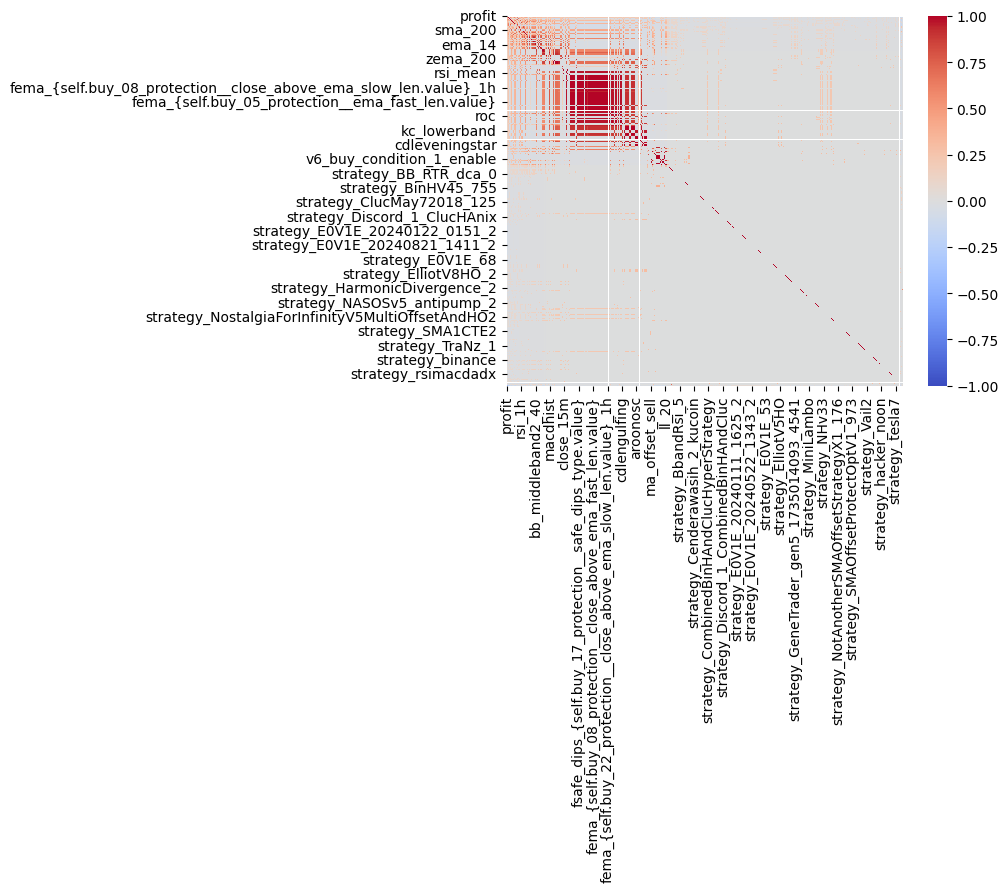

In [11]:
cat_cols = spots.select_dtypes(include=["object", "category"]).columns

dummies = pandas.get_dummies(spots[cat_cols], drop_first=False, dtype=int)

numeric_cols = spots.select_dtypes(include=["number", "bool"])

spots_all_numeric = pandas.concat([numeric_cols, dummies], axis=1)

corr = spots_all_numeric.corr()

sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1)

### Futures

In [9]:
futures = df[df["mode"] == "Futures"]

futures.sort_values("profit", ascending=False).head(25)

,strategy,mode,scope,bias,timeframe,profit,short,close,rsi,volume,...,v8_buy_condition_2_enable,v8_buy_condition_3_enable,slowingdown,delta,continueup,ll_20,avg_val_20,avg_hh_ll_20,avg_close_20,linreg_val_20
3127,RsiquiV3,Futures,Public,Unbiased,5m,121904.984000,1,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,RsiquiV2,Futures,Public,Unbiased,5m,32918.620800,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3916,ZTV16,Futures,Public,Unbiased,5m,20886.727950,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,RsiquiV3_2,Futures,Public,Unbiased,5m,10991.870417,1,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3904,ZaratustraV8,Futures,Public,Unbiased,5m,9601.297714,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3129,RsiquiV4,Futures,Public,Unbiased,5m,7550.276250,1,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1717,el,Futures,Public,Unbiased,5m,2684.988785,1,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3882,ZaratustraV13,Futures,Public,Unbiased,5m,2052.687830,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3907,ZarTest02,Futures,Public,Unbiased,5m,1751.607105,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3269,SlopeV5,Futures,Public,Unbiased,15m,1729.495071,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

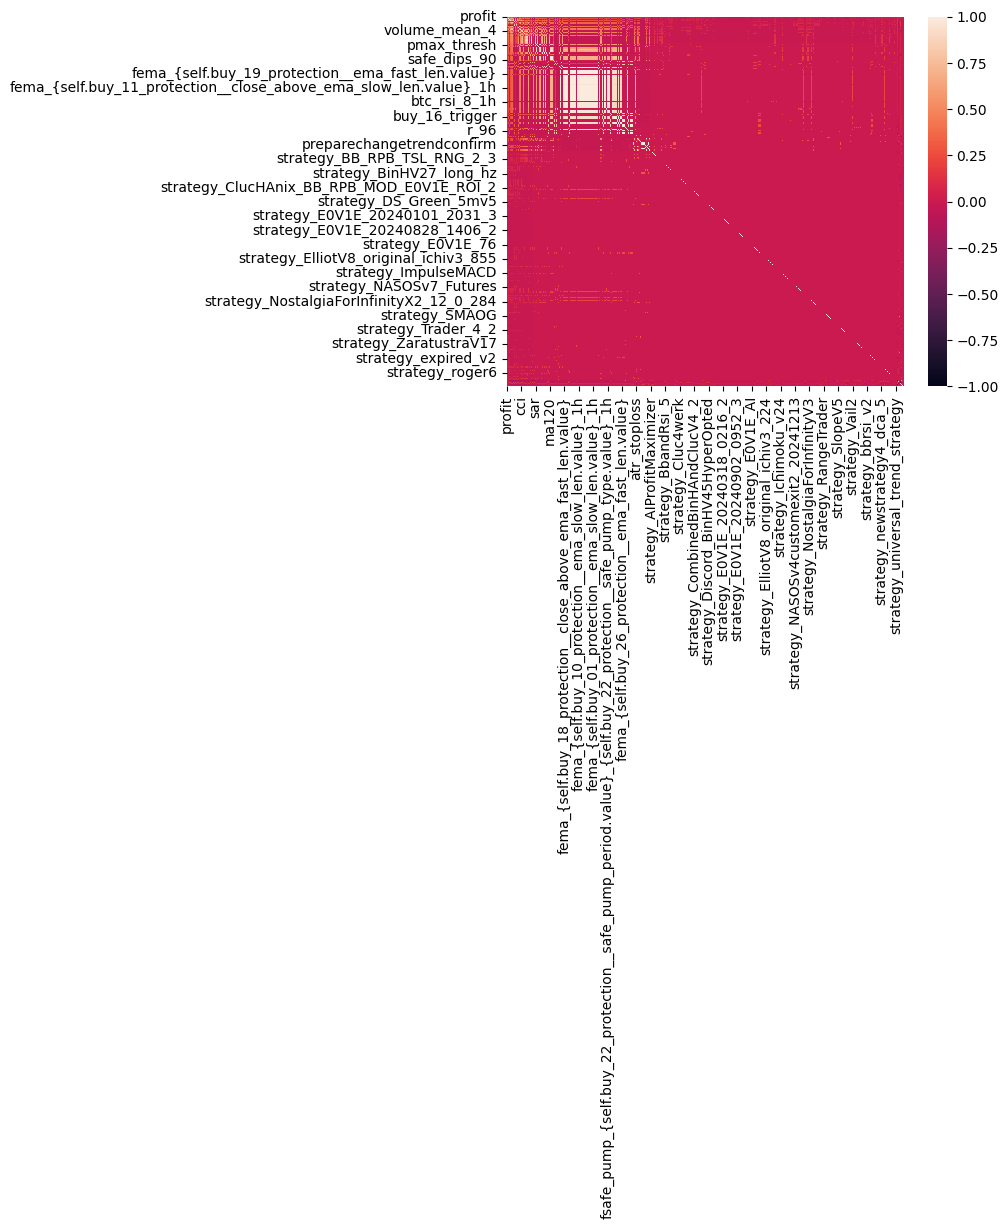

In [ ]:
cat_cols = futures.select_dtypes(include=["object", "category"]).columns

dummies = pandas.get_dummies(futures[cat_cols], drop_first=False, dtype=int)

numeric_cols = futures.select_dtypes(include=["number", "bool"])

futures_all_numeric = pandas.concat([numeric_cols, dummies], axis=1)

corr = futures_all_numeric.corr()

sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1)